# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression
## **Part b)** - Feed-Forward Neural Network

#### Program imports and defaults

In [4]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

#### Dataset setup and preprocessing

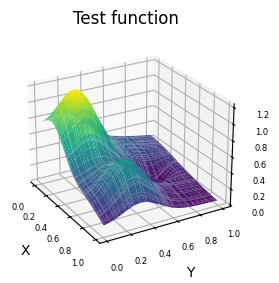

In [5]:
anp.random.seed(def_seed)
cases = ['1D','2D','Franke']
case_ = cases[2]
show = True #True False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                            # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
if case_ == '1D':
    f = dataset.plot(labels=['Test function','x','y','dataset','true'])
else:
    f = dataset.plot(labels=['Test function','X','Y','Z'])

if case_ == '1D':
    targets = dataset.target[0]
    inputs = dataset.x

else:
    targets = dataset.target_f
    x = dataset.xf; y = dataset.yf
    inputs = anp.zeros((x.shape[0],2))
    inputs[:,0] = x[:,0]
    inputs[:,1] = y[:,0] 

test_size = 1/5
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=test_size,random_state=def_seed)
#inputs_train, inputs_test, targets_train, targets_test = inputs,inputs,targets,targets
## Data scaling
scaler = StandardScaler() #StandardScaler() MinMaxScaler()
scaler.fit(inputs_train)
scale = False
if scale == True:
    inputs_train_s = scaler.transform(inputs_train)
    inputs_test_s = scaler.transform(inputs_test)
else:
    inputs_train_s = inputs_train
    inputs_test_s = inputs_test

### Feed-Forward Neural Network analysis
#### Training network with fixed parameters $\eta, \gamma, \lambda$
Simple training of the network with fixed parameters for the learning rate $\eta$, regularization, $\lambda$, gradient momentum, $\gamma$, as well as a fixed number of mini-batches and epochs.

Method: ADAM
Regularization, λ: 5e-05
Learning rate,  η: 1e-05
MSE:  0.08636900170378842
R² :  0.015860741955121438


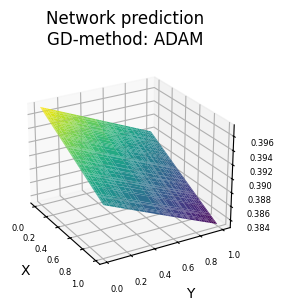

In [ ]:
anp.random.seed(def_seed)

n_inputs,n_features = inputs_train_s.shape

layer_output_sizes = [5,5,5,5,5,1]

hidden_func = LeakyReLU #sigmoid ReLU, ELU, LeakyReLU,identity
hidden_der  = LeakyReLU_der # ReLU_der sigmoid_der #elementwise_grad(hidden_func,0)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(identity); 
output_der = identity #elementwise_grad(act_funcs[-1],0);
act_ders.append(output_der)

cost_func = mse_predict
cost_der  = grad(cost_func,0)

network = FFNNetwork(network_input_size=n_features,layer_output_size=layer_output_sizes,
                         activation_functions=act_funcs,activation_derivatives=act_ders,
                         cost_function=cost_func,cost_derivative=cost_der)
network.reset()
network.create_layers()

## Gradient Descent setup
eta = 1e-5
gamma = 1e-8
lmbda = 5e-5; lp = 2
adagrad_mom = gamma
decay_rms = 0.9
ADAM_decay = [0.9, 0.99]

batches = 128; epoch = 1000

## Calling the gradient descent (GD)-method
#GDMethod = PlainGD(eta,lmbda=lmbda,lp=lp)
#GDMethod = MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)
#GDMethod = Adagrad(eta,adagrad_mom,lmbda=lmbda,lp=lp)
#GDMethod = RMSprop(eta,decay=decay_rms) 
GDMethod = ADAM(eta,ADAM_decay,lmbda=lmbda)

network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

final_predict = network.feed_forward(inputs_test_s)
show = True
if show == True:
    print(f'Method: {GDMethod.__class__.__name__}')
    print('Regularization, λ:',lmbda)
    print('Learning rate,  η:',eta)
    print('MSE: ',mse_predict(final_predict,targets_test))
    print('R² : ',network.score(inputs_test_s,targets_test))

final_full_fit = network.feed_forward(inputs)
if case_ == '1D':
    plot1D(input,[targets_test,final_predict],
           labels=[f'Network prediction\nGD-method: {GDMethod.__class__.__name__}, {hidden_func.__class__.__name__}'
                                                ,'x','y','f (x)','ỹ (x)','',''])
else:
    final_fit = final_full_fit.reshape(Nx,Ny)
    plot2D(dataset.xx,dataset.yy,final_fit,
           labels=[f'Network prediction\nGD-method: {GDMethod.__class__.__name__}'
                                                   ,'X','Y','Z'])

#### Repeated training with same parameters

Training iteration 0
Current cost: 0.08688227810171548
Training iteration 5
Cost increasing, terminating.
Trained network 5 times
Final best cost: 0.08583070172616239
Final best cost: 0.08579203800850337
R²-score       : 0.021994448842267422
R²-score 0.021994448842267422


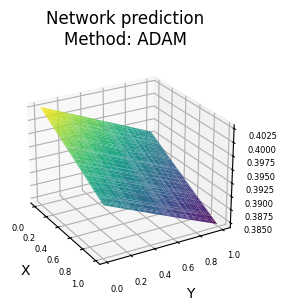

In [ ]:
anp.random.seed(def_seed)

network = FFNNetwork(network_input_size=n_features,layer_output_size=layer_output_sizes,
                         activation_functions=act_funcs,activation_derivatives=act_ders,
                         cost_function=cost_func,cost_derivative=cost_der)

network.reset()
network.create_layers()

## Gradient Descent setup
#eta = 1e-5
gamma = 1e-8
#lmbda = 5e-14; lp = 2
adagrad_mom = gamma
decay_rms = 0.9
ADAM_decay = [0.99, 0.999]

#batches = 128; epoch = 1000

#GDMethod = MomentumGD(eta,gamma,lmbda,lp)
#GDMethod = Adagrad(eta,adagrad_mom,lmbda=lmbda,lp=lp)
#GDMethod = RMSprop(eta,decay=decay_rms) 
GDMethod = ADAM(eta,ADAM_decay,lmbda=lmbda)

cost = 1000; tol = 0.005; iter = 0
while cost > tol and iter < 100:
    network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)
    
    ## Storing cost from previous for terminating the loop if cost starts to increase
    old_cost = cost
    
    cost = network.cost(inputs_test_s,targets_test)
    r2 = network.score(inputs_test_s,targets_test)

    if iter % 10 == 0:
        print('Training iteration %i' %(iter))
        print('Current cost:',cost)

    if old_cost < cost:
        print('Training iteration %i' %(iter))
        print('Cost increasing, terminating.')
        break
    
    iter += 1

print('Trained network %i times' %(iter))
print('Final best cost:',cost)
print('Final best cost:',old_cost)
print('R²-score       :',network.score(inputs_test_s,targets_test))
print('R²-score',r2)
fin_pred = network.predict(inputs)

_ = plot2D(dataset.xx,dataset.yy,fin_pred.reshape(Nx,Ny),
           labels=[f'Network prediction\nMethod: {GDMethod.__class__.__name__}'
                                                   ,'X','Y','Z'])

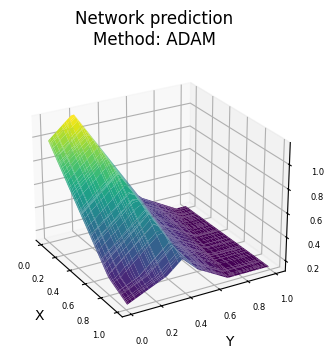

In [95]:
fin_pred = network.predict(inputs)

_ = plot2D(dataset.xx,dataset.yy,fin_pred.reshape(Nx,Ny),
           labels=[f'Network prediction\nMethod: {GDMethod.__class__.__name__}'
                                                   ,'X','Y','Z'],save=True,f_name='fin_pred_adam_lin.png')

#### Grid search for best combination, $\eta$ and $\lambda$

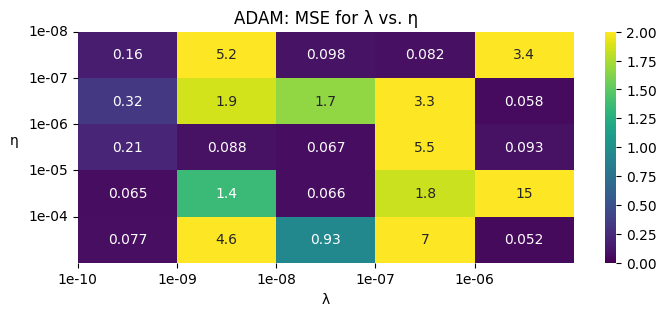

In [ ]:
anp.random.seed(def_seed)

## Resetting some instance variables of the network before next run
network.reset()

## To show outputs to 
show = False

## SDG-parameters
num_param = 5
eta = anp.logspace(-8,-4,num_param)
lmbda = anp.logspace(-10,-6,num_param); lp = 2
gamma = 1e-8
adagrad_mom = gamma
decay_rms = 0.9
ADAM_decay = [0.9, 0.99]

batches = 32; epoch = 1000

MSE_NN = anp.zeros((len(eta),len(lmbda)))
for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Recreating the layers
        network.create_layers()
        
        #ADAM_decay[0] = ADAM_decay1[j] 
        ## Calling GDMethod with new parameters
        #GDMethod = PlainGD(eta[i],lmbda=lmbda[j],lp=lp)
        #GDMethod = MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)
        #GDMethod = Adagrad(eta[i],adagrad_mom,lmbda=lmbda[j],lp=lp)
        #GDMethod = RMSprop(eta[i],decay=decay_rms,lmbda=lmbda[j])
        GDMethod = ADAM(eta[i],ADAM_decay,lmbda=lmbda[j])

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

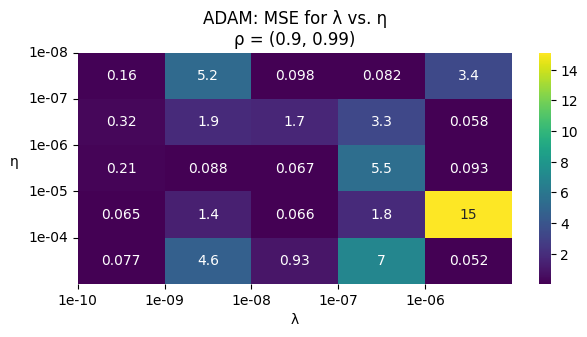

In [26]:
fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[MSE_NN.min(),MSE_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='viridis'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))

In [27]:
fig.savefig('grid_search_eta_lamb_adam_linreg_m32_e1000.png',dpi=300,bbox_inches='tight')

#### K-fold cross-validation

In [ ]:
from sklearn.model_selection import KFold
gamma = gamma
lmbdas = np.logspace(-10,-6,5)
eta = anp.logspace(-8,-4,10)
batches = 32
epoch = 100
num_folds = 5
kfold = KFold(n_splits=num_folds)

scores = {}
for i in range(len(lmbdas)):
    scores_eta = anp.zeros((len(eta),num_folds))
    for j in range(len(eta)):
        for k, (tr_idx,te_idx) in enumerate(kfold.split(inputs_train_s)):
            in_tr_k, in_te_k = inputs_train_s[tr_idx], inputs_train_s[te_idx]
            target_tr_k,target_te_k = targets_train[tr_idx], targets_train[te_idx]
    
            network.create_layers()
            #GDMethod = Adagrad(eta[j],gamma,lmbdas[i],lp=2)
            GDMethod = ADAM(eta[j],decay_rates=ADAM_decay,lmbda=lmbdas[i])

            network.train_network(in_tr_k,target_tr_k,GDMethod=GDMethod,batches=batches,epochs=epoch)
            
            scores_eta[j,k] = network.cost(in_te_k,target_te_k)

            network.reset()

    scores['mse_'+str(i)] = anp.mean(scores_eta,axis=1)  

['mse_0', 'mse_1', 'mse_2', 'mse_3', 'mse_4']
{'mse_0': array([1.06033919, 5.56963437, 2.30390044, 4.53209687, 5.76206778,
       0.62702021, 3.70411169, 1.70753685, 5.68680804, 8.41801245]), 'mse_1': array([1.07006369, 1.7184701 , 0.92465888, 1.02071407, 2.96356958,
       6.06546197, 4.59994774, 6.72150954, 1.75202457, 4.91190313]), 'mse_2': array([1.75384894, 3.07879159, 3.78926205, 2.06688234, 1.48650297,
       2.3504341 , 3.24118971, 4.41981317, 3.81830674, 0.91821295]), 'mse_3': array([0.93446856, 2.48773904, 2.61710817, 1.98912271, 3.46593505,
       2.89011351, 3.14023222, 1.56905991, 4.46868706, 1.26760834]), 'mse_4': array([1.9751229 , 2.91011623, 1.03126719, 3.21495139, 2.57183984,
       3.05174575, 4.14449795, 4.59601496, 4.25460101, 2.55332996])}
0.6270202123372308
0.9246588819081374
0.9182129451469289
0.9344685598513746
1.031267189204213


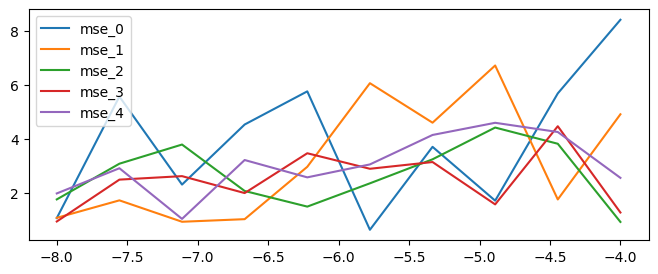

In [33]:
print(list(scores))
print(scores)
fig,ax = plt.subplots(1,1)
for i in list(scores):
    print(scores[i].min())
    ax.plot(anp.log10(eta),scores[i],label=i)
#ax.set_xlim([anp.log10(-6),anp.log10(-2)])
#ax.set_xlim([-6.1,-5]); ax.set_ylim([2,10]); 
_ = ax.legend()



#### Grid search, regularization, $\lambda$ vs. learning rate, $\eta$
Keeping the gradient descent momentum, $\gamma$, number of mini-batches and epochs fixed, this shows the training of the network with different values for the learning rate, $\eta$, and regularization term, $\lambda$. The `PlainGD`-method is a regularized stochastic gradient descent method if $\lambda = 0$, where the regularization order is set with the `lp`-keyword. The same holds for the `MomentumGD`-method.

In [ ]:
#anp.random.seed(def_seed)

## Resetting some instance variables of the network before next run
network.reset()

## To show outputs to 
show = False

## SDG-parameters
num_param = 8
eta = anp.logspace(-20,-10,num_param)
lmbda = anp.logspace(-4,0,num_param)
gamma = 0.00001; lp = 2
batches = 32; epoch = 200
ADAM_decay1 = anp.linspace(0.1,0.99,num_param)
ADAM_decay2 = anp.linspace(0.1,0.99,num_param)
adagrad_gamma = gamma
decay_rms = anp.logspace(-9,-8,num_param)
ADAM_decay = [0.9, 0.99]

MSE_NN = anp.zeros((len(eta),len(lmbda)))
for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Recreating the layers
        network.create_layers()
        
        #ADAM_decay[0] = ADAM_decay1[j] 
        ## Calling GDMethod with new parameters
        #GDMethod = [PlainGD(eta[i],lmbda=lmbda[j],lp=lp),PlainGD(eta[i],lmbda=lmbda[j],lp=lp)]
        #GDMethod = [MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp),MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)]
        GDMethod = [Adagrad(eta[i],adagrad_mom,lmbda=lmbda[j],lp=lp),Adagrad(eta[i],adagrad_mom,lmbda=lmbda[j],lp=lp)] #
        #GDMethod = [RMSprop(eta[i],decay=decay_rms[j]),RMSprop(eta[i],decay_rms[j])] 
        #GDMethod = [ADAM(eta[i],ADAM_decay),ADAM(eta[i],ADAM_decay)]

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod[0].__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

In [ ]:
fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.0,10.],
                    cmap='hot_r'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
_ = ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

fig.savefig('grid_search_eta_lamb_adagrad_linreg.png',dpi=300,bbox_inches='tight')

In [ ]:
anp.random.seed(def_seed)
network.create_layers()
#GDMethod = [RMSprop(learning_rate=5e-15,decay=4e-09),RMSprop(learning_rate=5e-15,decay=4e-09)]
#GDMethod = [ADAM(learning_rate=1e-20),ADAM(learning_rate=1e-20)]
GDMethod = [Adagrad(4e-20,gamma,2e-2,lp=1),Adagrad(4e-20,gamma,2e-2,lp=1)]
network.train_network(inputs,targets,GDMethod,batches=32,epochs=200)
final_fit = network.feed_forward(inputs)
print(network.cost(inputs_test_s,targets_test))
final_fit = final_fit.reshape(Nx,Ny)
plot2D(dataset.xx,dataset.yy,final_fit,
           labels=[f'Network prediction\nGD-method: {GDMethod[0].__class__.__name__}'
                                                   ,'X','Y','Z'])

#### Study of momentum, $\gamma$ vs. learning rate, $\eta$
Keeping the regularization parameter, $\lambda$, number of mini-batches and epochs fixed, this studies how the different values of learning rate, $\eta$, and gradient descent momentum, $\gamma$, affects the network training. The `PlainGD`-method is a regularized stochastic gradient descent method if $\lambda = 0$, where the regularization order is set with the `lp`-keyword. The same holds for the `MomentumGD`-method.

In [ ]:

anp.random.seed(def_seed)

network.reset()

#num_param = 4
eta = anp.logspace(-6,-2,num_param)
gamma = anp.logspace(-10,-6,num_param)
lmbda = 1e-7; lp = 2
#batches = 40; epoch = 100

MSE_NN = anp.zeros((len(eta),len(gamma)))
for i in range(len(eta)):
    for j in range(len(gamma)):
        network.create_layers()
        #GDMethod = [PlainGD(eta[i],lmbda=lmbda[j]),PlainGD(eta[i],lmbda=lmbda[j])]
        GDMethod = [MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp),MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp)]
        #GDMethod = [Adagrad(eta,adagrad_mom),Adagrad(eta,adagrad_mom)] #
        #GDMethod = [RMSprop(eta,decay=decay_rms),RMSprop(eta,decay_rms)] #
        #GDMethod = [ADAM(eta,ADAM_decay),ADAM(eta,ADAM_decay)] #

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod[0].__class__.__name__}')
            print('Momentum,       γ:',gamma[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

    network.reset()

fig,ax = lambda_eta(MSE_NN,[gamma,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in gamma],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for γ vs. η\nλ = %.0e'%(lmbda))
_ = ax.set_xlabel('γ')

#### Study of Adagrad momentum, $\gamma_{\text{adagrad}}$, and regularization, $\lambda$

In [ ]:
anp.random.seed(def_seed)

network.reset()

#num_param = 4
eta = 1e-5
adagrad_gamma = anp.logspace(-12,-6,num_param)
lmbda = anp.logspace(-10,-6,num_param)
lp = 2
#batches = 40; epoch = 100

MSE_NN = anp.zeros((len(lmbda),len(adagrad_gamma)))
for i in range(len(lmbda)):
    for j in range(len(adagrad_gamma)):
        network.create_layers()

        GDMethod = [Adagrad(eta,adagrad_gamma[j],lmbda=lmbda[i],lp=lp),Adagrad(eta,adagrad_gamma[j],lmbda=lmbda[i],lp=lp)]

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod[0].__class__.__name__}')
            print('Momentum,       γ:',gamma[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

    network.reset()

fig,ax = lambda_eta(MSE_NN,[adagrad_gamma,lmbda],
                    axis_tick_labels=[[f'{y:.0e}' for y in adagrad_gamma],[f'{y:.0e}' for y in lmbda]],
                    cbar_lim=[0.,2.]
                    )
ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for γ vs. λ\nη = %.0e'%(eta))
_ = ax.set_xlabel('γ'); _ = ax.set_ylabel('λ')

### Comparison with Scikit-Learn's Neural network implementation

/home/anders_tb/02-uio/fysstk4155/project-2-fys-stk4155/p2-venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.9745193176192432
Best loss: 0.0012387918271785476
Loss: 0.0012439774543972707


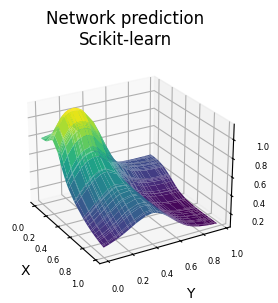

In [66]:
from sklearn.neural_network import MLPRegressor
eta_sk = 1e-1; lmbda_sk = 1e-8; gamma_sk = 1e-8
sklearn_network = MLPRegressor(layer_output_sizes,activation='logistic',solver='adam',#batch_size=16,
                               max_iter=1000,warm_start=True,#alpha=lmbda_sk,
                               learning_rate_init=eta_sk,
                               random_state=def_seed,#momentum=gamma_sk
                               )

sklearn_network.fit(inputs_train_s,targets_train)
final_pred = sklearn_network.predict(inputs_test_s)
print('Score:',sklearn_network.score(inputs_test_s,targets_test))
print('Best loss:',sklearn_network.best_loss_)
print('Loss:',sklearn_network.loss_)

final_pred = sklearn_network.predict(inputs)
if case_ == '1D':
    plot1D(input,[targets,final_pred],
           labels=[f'Network prediction\nScikit-learn'
                                                ,'x','y','f (x)','ỹ (x)','',''])
else:
    final_pred = final_pred.reshape(Nx,Ny)
    plot2D(dataset.xx,dataset.yy,final_pred,
           labels=[f'Network prediction\nScikit-learn'
                                                   ,'X','Y','Z'])
